In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy
import pandas
import root_numpy

In [3]:
import sys
sys.path.insert(0, "../")

# Prepare data

In [4]:
selection = " ((PIDNNk > 0) | (PIDNNm > 0) | (PIDNNe > 0) | (PIDNNpi > 0) | (PIDNNp > 0)) & (ghostProb < 0.4)"

In [5]:
from itertools import combinations
from utils import add_diff_pt, get_events_statistics

def add_features(data, event_id_column='event_id'):
    event_id = data.run.apply(str) + '_' + data.event.apply(int).apply(str)
    data['group_column'] = numpy.unique(event_id, return_inverse=True)[1]
    # all weights are 1, because this is MC
    data['N_sig_sw'] = 1
    data[event_id_column] = event_id
    
    add_diff_pt(data)
    # add cos(diff_phi)
    data.loc[:, 'cos_diff_phi'] = numpy.cos(data.diff_phi.values)
    PIDs = {'k': data.PIDNNk.values,
            'e': data.PIDNNe.values,
            'mu': data.PIDNNm.values,
           }
    for (pid_name1, pid_values1), (pid_name2, pid_values2) in combinations(PIDs.items(), 2):
        data.loc[:, 'max_PID_{}_{}'.format(pid_name1, pid_name2)] = numpy.maximum(pid_values1, pid_values2)
        data.loc[:, 'sum_PID_{}_{}'.format(pid_name1, pid_name2)] = pid_values1 + pid_values2
    data['label'] = data.signB.values * data.signTrack.values > 0

In [6]:
data = pandas.read_csv('../datasets/data/csv/WG/Bd_JPsiKstar/2012/Tracks.csv', sep='\t')
data = data.query('(Bmass < 5.4) & (Bmass > 5.16)')
add_features(data)
data.loc[~numpy.isfinite(data['IPs'].values), 'IPs'] = -999
data.loc[~numpy.isfinite(data['IPerr'].values), 'IPerr'] = -999
get_events_statistics(data)

/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


{'Events': 976359, 'parts': 32077555}

In [7]:
splot = pandas.read_csv('../datasets/data/csv/WG/Bd_JPsiKstar/2012/sPlot_Bd_JPsiKstar.csv',
                        sep=' ', header=None).drop([8], axis=1)
splot.columns = ['run', 'evTop', 'evBottom', 'Bmass', 'Nbkg_tot_sw', 'L_Nbkg_tot', 'Nsig_tot_sw', 'L_Nsig_tot']
event_id_column = 'event_id'

splot[event_id_column] = splot.run.apply(str) + '_' + (splot.evTop * 1e6 + splot.evBottom).apply(int).apply(str)
index = numpy.unique(splot[event_id_column], return_index=True)[1]
splot.index = numpy.arange(len(splot))
splot = splot.ix[index, :]

In [8]:
splot.index = splot[event_id_column]
data.index = data[event_id_column]

In [9]:
start = 0
end = 1000000
sweight = []
for batch in range(33):
    if end > len(data):
        end = len(data)
    sweight.append(splot.loc[data.index[start:end], 'Nsig_tot_sw'].values)
    start = end
    end += 1000000

In [10]:
sweight = numpy.concatenate(sweight)
data.N_sig_sw = sweight

In [11]:
N_B_events = numpy.sum(splot.Nsig_tot_sw)
N_B_events

278815.27542189573

In [12]:
data = data.query(selection)
data = data.query("(time >= 0.2) & (time <= 8)")

# Read models

### data models

In [13]:
import cPickle
with open('../models/dt_WG_2012.pkl', 'r') as f:
    tt_folding = cPickle.load(f)
with open('../models/calibrator_tracks_WG_2012.pkl', 'r') as f:
    calibrator_tracks = cPickle.load(f)
    
with open('../models/calibrator_B_WG_2012.pkl', 'r') as f:
    calibrator_B = cPickle.load(f)
    
with open('../models/loss_dt/dt_ss_os.pkl', 'r') as f:
    tt_os_ss = cPickle.load(f)
with open('../models/loss_dt/os_ss_calibrator.pkl', 'r') as f:
    calibrator_os_ss = cPickle.load(f)

### MC models

In [14]:
import cPickle
with open('../models/dt_kstar_MC.pkl', 'r') as f:
    tt_folding_MC = cPickle.load(f)
with open('../models/calibrator_tracks_kstar_MC.pkl', 'r') as f:
    calibrator_tracks_MC = cPickle.load(f)
    
with open('../models/calibrator_B_kstar_MC.pkl', 'r') as f:
    calibrator_B_MC = cPickle.load(f)

In [28]:
import cPickle
with open('../models/dt_MC.pkl', 'r') as f:
    tt_folding_MC_k = cPickle.load(f)
with open('../models/calibrator_tracks_MC.pkl', 'r') as f:
    calibrator_tracks_MC_k = cPickle.load(f)
    
with open('../models/calibrator_B_MC.pkl', 'r') as f:
    calibrator_B_MC_k = cPickle.load(f)

# Predict by data model

In [15]:
from utils import compute_B_prob_using_part_prob
part_probs = tt_folding.predict_proba(data)[:, 1]
prior = tt_os_ss.predict_proba(data)[:, 1]

part_probs_calib = calibrator_tracks.predict_proba(part_probs)
prior_calib = calibrator_os_ss.predict_proba(prior)

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


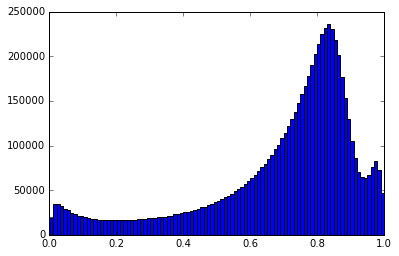

In [16]:
hist(prior_calib, bins=100, weights=data.N_sig_sw.values);

In [17]:
part_probs_union_pid = part_probs_calib.copy()
mask = data.PIDNNpi.values > 0.8
part_probs_union_pid[mask] = 1 - part_probs_union_pid[mask]

In [18]:
part_probs_union = prior_calib*(1 - part_probs_calib) + (1-prior_calib)*part_probs_calib

In [19]:
Bsign, Bweight, Bprobs, Bevent = compute_B_prob_using_part_prob(data, part_probs_union, 
                                                                sign_part_column='signTrack')
Bprobs_calib = calibrator_B.predict_proba(Bprobs)
mistag = numpy.minimum(Bprobs_calib, 1 - Bprobs_calib)
tag = numpy.ones(len(Bprobs_calib))
tag[Bprobs_calib < 0.5] = -1

In [20]:
Bsign_pid, Bweight_pid, Bprobs_pid, Bevent_pid = compute_B_prob_using_part_prob(data, part_probs_union_pid, 
                                                                                sign_part_column='signTrack')
Bprobs_calib_pid = calibrator_B.predict_proba(Bprobs_pid)
mistag_pid = numpy.minimum(Bprobs_calib_pid, 1 - Bprobs_calib_pid)
tag_pid = numpy.ones(len(Bprobs_calib_pid))
tag_pid[Bprobs_calib_pid < 0.5] = -1

# Predict by MC-kstar model

In [30]:
from utils import compute_B_prob_using_part_prob
part_probs_mc = tt_folding_MC.predict_proba(data)[:, 1]
part_probs_calib_mc = calibrator_tracks_MC.predict_proba(part_probs_mc)
Bsign_mc, Bweight_mc, Bprobs_mc, Bevent_mc = compute_B_prob_using_part_prob(data, part_probs_calib_mc, 
                                                                            sign_part_column='signTrack')
Bprobs_calib_mc = calibrator_B_MC.predict_proba(Bprobs_mc)
mistag_mc = numpy.minimum(Bprobs_calib_mc, 1 - Bprobs_calib_mc)
tag_mc = numpy.ones(len(Bprobs_calib_mc))
tag_mc[Bprobs_calib_mc < 0.5] = -1

KFold prediction using random classifier (length of data passed not equal to length of train)


# Predict by MC model

In [31]:
from utils import compute_B_prob_using_part_prob
part_probs_mc_k = tt_folding_MC_k.predict_proba(data)[:, 1]
part_probs_calib_mc_k = calibrator_tracks_MC_k.predict_proba(part_probs_mc_k)
part_probs_union_mc_k = prior_calib*(1 - part_probs_calib_mc_k) + (1-prior_calib)*part_probs_calib_mc_k

Bsign_mc_k, Bweight_mc_k, Bprobs_mc_k, Bevent_mc_k = compute_B_prob_using_part_prob(data, part_probs_union_mc_k, 
                                                                                    sign_part_column='signTrack')
Bprobs_calib_mc_k = calibrator_B_MC_k.predict_proba(Bprobs_mc_k)
mistag_mc_k = numpy.minimum(Bprobs_calib_mc_k, 1 - Bprobs_calib_mc_k)
tag_mc_k = numpy.ones(len(Bprobs_calib_mc_k))
tag_mc_k[Bprobs_calib_mc_k < 0.5] = -1

KFold prediction using random classifier (length of data passed not equal to length of train)


# Prepare for EPM

In [21]:
ids = numpy.unique(data.event_id, return_index=True)[1]
data.index = numpy.arange(len(data))
Bmass = data.ix[ids, 'Bmass'].values
Btime = data.ix[ids, 'time'].values

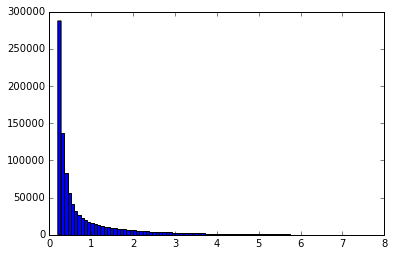

In [22]:
hist(Btime, bins=100);

In [23]:
assert sum(data.ix[ids, 'event_id'] != Bevent) == 0

In [24]:
from utils import get_events_number
N_B_passed = float(get_events_number(data))
tagging_efficiency = N_B_passed / N_B_events
tagging_efficiency_delta = sqrt(tagging_efficiency * (1 - tagging_efficiency) * \
                                numpy.sum(splot.Nsig_tot_sw.values ** 2)) / N_B_events
tagging_efficiency, tagging_efficiency_delta

(0.97607071342320739, 0.00036564172912067366)

In [25]:
prepared_data = pandas.DataFrame({'tag': numpy.array(tag, dtype='int32'),
                                  'mistag': mistag,
                                  'flavour': numpy.array(Bsign, dtype='int32'),
                                  'decay_time': Btime,
                                  'Bmass': Bmass,
                                  'resolution': [50*1e-3] * len(Bmass),
                                  'probs': Bprobs_calib,
                                  'weight': Bweight
                                 })

root_numpy.array2root(prepared_data.to_records(index=False), "../for_epm/kstar.root", 
                      mode='recreate')

In [32]:
numpy.average((1 - 2*Bprobs_calib)**2, weights=Bweight)

0.044743147191932453

In [33]:
prepared_data = pandas.DataFrame({'tag': numpy.array(tag_pid, dtype='int32'),
                                  'mistag': mistag_pid,
                                  'flavour': numpy.array(Bsign_pid, dtype='int32'),
                                  'decay_time': Btime,
                                  'Bmass': Bmass,
                                  'resolution': [50*1e-3] * len(Bmass),
                                  'probs': Bprobs_calib_pid,
                                  'weight': Bweight_pid
                                 })

root_numpy.array2root(prepared_data.to_records(index=False), "../for_epm/kstar_pid_inverting.root", 
                      mode='recreate')

In [34]:
numpy.average((1 - 2*Bprobs_calib_pid)**2, weights=Bweight_pid)

0.073242491295079676

In [35]:
prepared_data = pandas.DataFrame({'tag': numpy.array(tag_mc, dtype='int32'),
                                  'mistag': mistag_mc,
                                  'flavour': numpy.array(Bsign_mc, dtype='int32'),
                                  'decay_time': Btime,
                                  'Bmass': Bmass,
                                  'resolution': [50*1e-3] * len(Bmass),
                                  'probs': Bprobs_calib_mc,
                                  'weight': Bweight_mc
                                 })

root_numpy.array2root(prepared_data.to_records(index=False), "../for_epm/kstar_mc_kstar.root", 
                      mode='recreate')

In [36]:
numpy.average((1 - 2*Bprobs_calib_mc)**2, weights=Bweight_mc)

0.054693134294901705

In [37]:
prepared_data = pandas.DataFrame({'tag': numpy.array(tag_mc_k, dtype='int32'),
                                  'mistag': mistag_mc_k,
                                  'flavour': numpy.array(Bsign_mc_k, dtype='int32'),
                                  'decay_time': Btime,
                                  'Bmass': Bmass,
                                  'resolution': [50*1e-3] * len(Bmass),
                                  'probs': Bprobs_calib_mc_k,
                                  'weight': Bweight_mc_k
                                 })

root_numpy.array2root(prepared_data.to_records(index=False), "../for_epm/kstar_mc_k.root", 
                      mode='recreate')

In [38]:
numpy.average((1 - 2*Bprobs_calib_mc_k)**2, weights=Bweight_mc_k)

0.052282346370030493